In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from astropy.table import Table

/Users/alice/Library/Caches/pypoetry/virtualenvs/gammainc-OwKpwFa2-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
###--------------------------------------------------NEW IMPORT-------------------------------------------------###
from gammainc import custom_gammaincc
###--------------------------------------------------NEW IMPORT-------------------------------------------------###

In [3]:
def load_and_filter_data(filename, zmin, zmax, logm_limit, absmag_limit):
    """
    Load GAMA data from a FITS file and apply basic selection criteria:
      - Redshift between zmin and zmax
      - log(stellar mass) > logm_limit
      - absolute magnitude < absmag_limit

    Returns
    -------
    logmstar : ndarray
        Filtered array of log10(stellar mass).
    absmag : ndarray
        Filtered array of absolute magnitudes (i band).
    """
    data = Table.read(filename)
    data = data[(data['Z'] > zmin) & (data['Z'] < zmax)]

    logmstar_full = np.asarray(data['logmstar'])
    absmag_full   = np.asarray(data['absmag_i'])

    masssel = (logmstar_full > logm_limit) & (logmstar_full < 12)
    abssels = absmag_full < absmag_limit
    bothsel = masssel & abssels

    logmstar = logmstar_full[bothsel]
    absmag   = absmag_full[bothsel]

    # Ensure these arrays are in a JAX-friendly dtype (e.g., float64).
    logmstar = logmstar.astype(np.float64)
    absmag   = absmag.astype(np.float64)

    print(f"Number of objects after cuts: {len(logmstar)}")
    return logmstar, absmag

In [4]:
def schechter_log(alpha, logm0, logm):
    """
    Schechter function, in "log(M)" space (returns the unnormalized PDF).
    we skip the uppergamma normalization and let jnp.trapezoid handle it.
    
    alpha, logm0 : scalars
    logm         : array of log10(M) points
    """
    ln10 = jnp.log(10.)
    M = 10.0 ** logm
    M0 = 10.0 ** logm0
    t = M / M0
    
    # phi_linear = (1/M0) * t^alpha * exp(-t)
    phi_linear = (1.0 / M0) * t**alpha * jnp.exp(-t)
    
    # phi_log = phi_linear * M * ln(10)
    # (This is the PDF in log(M) space rather than M space.)
    phi_log = phi_linear * M * ln10
    return phi_log

In [5]:
def model(logm, logm_limit):
    """
    NumPyro model: draws alpha, logm0 from priors,
    numerically normalizes single_schechter_in_logm over [logm_limit, max(logm)+1],
    then adds the sum of log-likelihood for the observed data.
    """
    # -- 1) PRIORS --
    # Define the priors for the parameters
    alpha = numpyro.sample("alpha", dist.Uniform(-3.0, 0.0))
    logm0 = numpyro.sample("logm0", dist.Uniform(8.0, 12.0))


    # -- 2) NUMERIC INTEGRATION FOR NORMALIZATION --
    # upper_bound = 15.0 #jnp.max(logm) + 1.0
    # logm_grid   = jnp.linspace(logm_limit, upper_bound, 300)

    # unnormalized PDF on a grid
    # pdf_grid = schechter_log(alpha, logm0, logm_grid)
    # numeric integral
    # norm = jnp.trapezoid(pdf_grid, logm_grid)
    # guard against near-zero
    # norm = jnp.where(norm > 1e-40, norm, jnp.inf)
    ###--------------------------------------------------IMPORTANT-------------------------------------------------###
    '''we change this norm with the jax uppergamma'''
    ###--------------------------------------------------IMPORTANT-------------------------------------------------###

    ###--------------------------------------------------NEW CODE-------------------------------------------------###
    # Inputs taken from EMCEE fitting notebook
    M0 = 10.0**(logm0)
    t_lim = (10.0**(logm_limit)) / M0
    
    # Call custom JAX upper incomplete gamma function
    norm = custom_gammaincc(alpha + 1, t_lim)
    # Guard against near-zero
    norm = jnp.where(norm > 1e-40, norm, jnp.inf)
    ###--------------------------------------------------NEW CODE-------------------------------------------------###

    # -- 3) LIKELIHOOD EVAL FOR DATA --
    pdf_data = schechter_log(alpha, logm0, logm) / norm
    pdf_data_clipped = jnp.clip(pdf_data, 1e-30, jnp.inf)

    loglik = jnp.sum(jnp.log(pdf_data_clipped))
    
    numpyro.factor("likelihood", loglik)

In [6]:
def run_mcmc_numpyro(logm, logm_limit, num_warmup=2000, num_samples=2000):
    """
    Runs MCMC using NUTS to sample from the posterior over (alpha, logm0).

    Parameters
    ----------
    logm       : 1D array of observed log10(stellar masses).
    logm_limit : float, lower log(M) for numerical integration
    num_warmup : int, number of warmup steps
    num_samples: int, number of post-warmup draws

    Returns
    -------
    mcmc : MCMC object containing samples, diagnostics, etc.
    """
    # NUTS kernel for HMC
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)

    # Run MCMC
    rng_key = jax.random.PRNGKey(0)
    mcmc.run(rng_key, logm, logm_limit)

    return mcmc

Number of objects after cuts: 10692


sample: 100%|██████████| 7000/7000 [00:10<00:00, 641.10it/s, 7 steps of size 4.75e-01. acc. prob=0.94] 


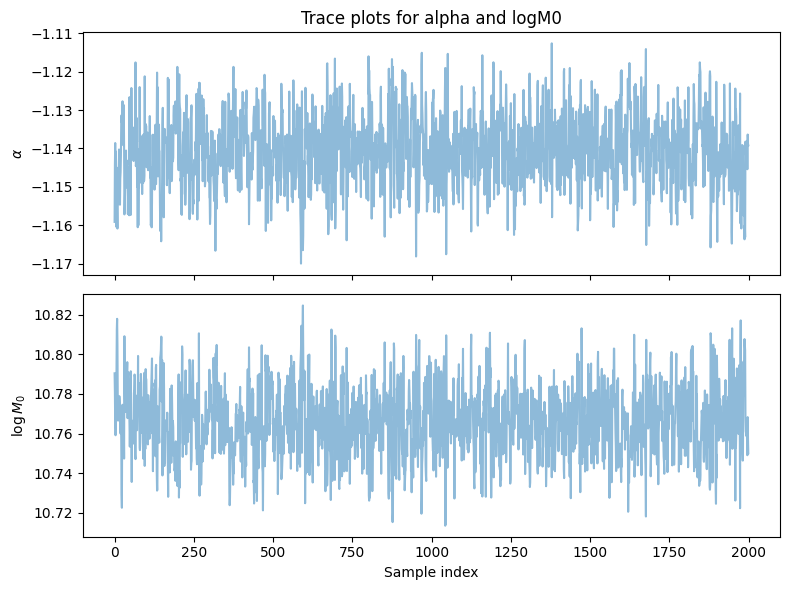

Posterior mean of alpha = -1.140
Posterior mean of logM0 = 10.766


In [7]:
def main_numpyro():
    """
    Example driver that:
      1) loads and filters data
      2) runs NumPyro MCMC
      3) plots alpha & logm0 trace
      4) prints posterior means
    """
    # --- (1) Load data ---
    filename = 'StellarMassesGKVv24.fits'
    logm_limit = 8.6    # Keep log10(M) > 8.5
    absmag_limit = -17  # Keep absolute magnitude < -17
    z_min, z_max = 0.005, 0.065

    logmstar, absmag = load_and_filter_data(filename, z_min, z_max, logm_limit, absmag_limit)

    # --- (2) Run MCMC with NumPyro ---
    mcmc = run_mcmc_numpyro(logmstar, logm_limit=logm_limit,
                            num_warmup=5000, num_samples=2000)

    samples = mcmc.get_samples()  # dict with "alpha" and "logm0"

    # --- (3) Plot the trace for alpha & logm0 ---
    alpha_chain = samples["alpha"]
    logm0_chain = samples["logm0"]

    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
    axes[0].plot(alpha_chain, alpha=0.5)
    axes[0].set_ylabel(r"$\alpha$")

    axes[1].plot(logm0_chain, alpha=0.5)
    axes[1].set_ylabel(r"$\log M_0$")
    axes[1].set_xlabel("Sample index")

    axes[0].set_title("Trace plots for alpha and logM0")
    plt.tight_layout()
    plt.show()

    # --- (4) Print some summaries ---
    alpha_mean = np.mean(np.array(alpha_chain))
    logm0_mean = np.mean(np.array(logm0_chain))
    print(f"Posterior mean of alpha = {alpha_mean:.3f}")
    print(f"Posterior mean of logM0 = {logm0_mean:.3f}")

    return logmstar, alpha_mean, logm0_mean

if __name__ == "__main__":
    logmstar, alpha_mean, logm0_mean = main_numpyro()

In [10]:
def plot_hist_and_model(logmstar, params, scale, logm_limit, model_type='single'):
    """
    Plots a histogram of data in log10(M*) along with the normalized Schechter model.

    logmstar   : array of observed log10(M*)
    params     : best-fit parameters (e.g. [alpha, logM0]) 
    scale      : a factor to rescale model if desired 
    logm_limit : lower limit in log(M*) for normalization
    model_type : which Schechter model, here only 'single' is handled
    
    """
    plt.figure(figsize=(8, 5))

    # Histogram of data, normalized
    bins = np.arange(logm_limit, 12.0, 0.05)
    plt.hist(logmstar, bins=bins, density=True, alpha=0.5, label="Data (normalized)")

    # Evaluate the model at midpoints of each bin
    logm_grid = 0.5 * (bins[:-1] + bins[1:])

    # Build a label
    if model_type == 'single':
        alpha, logm0 = params
        label_str = f"Single Schechter (α={alpha:.2f}, logM₀={logm0:.2f})"
    else:
        # additional model types would be handled here
        raise ValueError("Currently only 'single' is implemented in this numeric example.")

    # Evaluate the numeric Schechter model
    phi = schechter_log(alpha, logm0, logm_grid)
    
    #normalize the schechter function to match the hist
    norm = jnp.trapezoid(phi, logm_grid)
    norm = jnp.where(norm > 1e-40, norm, jnp.inf)
    phi_norm = phi / norm

    # Plot model
    plt.plot(logm_grid, scale * phi_norm, 'r-', lw=2, label=label_str)
    plt.xlabel(r"$\log_{10}(M_{\star})$")
    plt.ylabel("Normalized density")
    plt.yscale("log")
    plt.ylim(1e-2, 1e0)
    plt.legend()
    plt.title("Mass Function Fit using (Numeric) Schechter Model")
    plt.show()

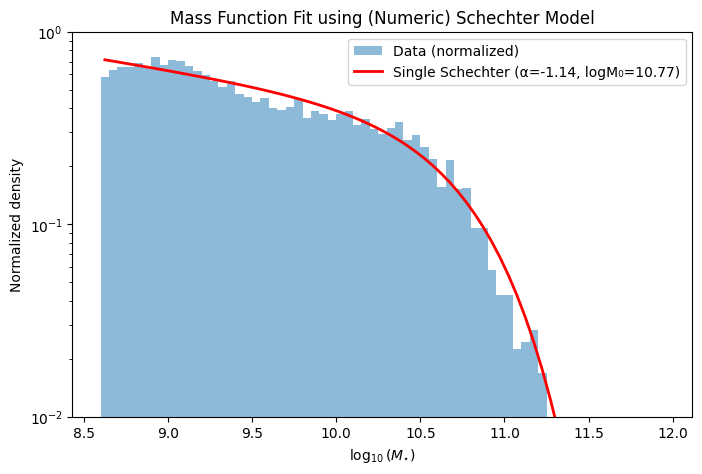

In [11]:
plot_hist_and_model(
    logmstar,
    params=[alpha_mean, logm0_mean],
    scale=1.0,           # scale factor for matching histogram's y-axis
    logm_limit=8.6,      # same lower limit used during sampling
    model_type='single'
)